# HW1: Linear classifiers
    
In this homework assignment, we'll compare two linear classifiers: logistic regression and perceptron on the task of language identification. 

Before you start, rename the notebook to HW2_linear_classifiers_firstname.ipynb. E.g. HW2_linear_classifiers_miikka.ipynb.

Our tasks include:

1. Reading training, development and test data
1. Implementing a feature extraction function for language identification
1. Implementing a baseline majority classifier
1. Training and fine-tuning logistic regression and perceptron classifiers using Sklearn.
1. Evaluation of classification performance including a significance test.
1. Figuring out top features for both classifiers. 
1. Writing short report on your findings.

Grading criteria for code:

* Readability of code
* Correctness of code and solution
* Appropriate code commenting
* Your code should be reasonably efficient. No need to optimize too much but (apart from fine-tuning code) it should be possible to run the entire notebook in 30 minutes.

Grading criteria for the half-page report (in assignment 7. Evaluation):

* Clear explanation of what you did
* Clear explanation of your observations concerning the output of the classifier.
* You need to include answers to the questions posed in assignment 1-6.

The deadline for this assignment is Sunday November 5 at 23:59 PT. Please upload your notebook to Canvas or email it to Miikka (msilfver@mail.ubc.ca). No need to include the datasets.

## 1. Reading training, development and test data (5 points)

You task is to distinguish between short sentence fragments in English, French, German and Swedish. You will get three data files for this assignment:

* `lang.train.tsv` for training your model
* `lang.dev.tsv` for fine-tuning model parameters
* `lang.test.tsv` for final testing of your models including significance tests

The data in all files has the same format. Two tab-separated columns: (1) the sentence fragment, (2) the language tag (de for German, en for English, fr for French, sv for Swedish):

```
text                    language
même prix je me         fr
je préfère ignorer son  fr
die mediation           de
two                     en
to end                  en
```

You should read these files into three Pandas data frames.

In [9]:
import pandas as pd
from collections import defaultdict, Counter
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score, roc_curve, RocCurveDisplay
from sklearn.linear_model import LogisticRegression, Perceptron
import numpy as np
from scipy.stats import wilcoxon, ttest_rel
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
# loading datasets
train = pd.read_csv("lang.train.tsv",  sep = "\t")
dev = pd.read_csv("lang.dev.tsv", sep = "\t")
test = pd.read_csv("lang.test.tsv", sep = "\t")

print(train)

                            text language
0                même prix je me       fr
1         je préfère ignorer son       fr
2                  die mediation       de
3                            two       en
4                         to end       en
...                          ...      ...
4813               et morte le 2       fr
4814   il comptait 249 habitants       fr
4815          links zu von sears       de
4816  clemens gerth zirka kunden       de
4817         die abschaffung der       de

[4818 rows x 2 columns]


## 2. Feature extraction (20 points)

You are allowed to use any approach you like for feature extraction. One idea is to use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) but you can also extract your features manually and apply [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer.get_feature_names_out) (note, that the class names are links to the sklearn documentation)

If you end up using CountVectorizer, note that it by default only extracts **word** n-grams. While this can give you reasonable performance, it probably isn't the best approach because words like "abschaffung" are rare and word-based features are unlikely to generalize well to test data. Instead, it might be a better idea to extract **substrings** of the sentence fragment like "absch" which can generalize far better. To this end, you might want to take a look at the parameter `analyzer` in the CountVectorizer class.

Even though most words are rare, there are words like "a", "the", "is" in English and "le", "la" and "est" in French which can be good and frequent features. You might want to include some of these even though they might, at least partly, be covered by your character n-grams.

You have great freedom to extract features any way you like. You don't need to limit yourself to the predefined sklearn features. You can even use external resources like dictionaries for this task if you want. For example, the [Unimorph](https://unimorph.github.io/) project provides huge lists of inflected word forms for all of our target languages. Checking how many of the words in the sentence fragment are present in the English, French, German or Swedish word list could be a nice feature.

Note, that you will fine-tune your feature set in assignment 4. For example, you might adjust the size of the character n-grams which are included as features. For now, use reasonable guesses and revisit the question when you get to assignment 4.  

Store your features in the arrays `train_X`, `dev_X` and `test_X`.

In your report (question 7), you should describe your feature set.

In [3]:
# get inflected word forms for each language
en_url = 'https://raw.githubusercontent.com/unimorph/eng/master/eng'
en_df = pd.read_csv(en_url,header = None, names = ["stem", "inflected", "form"], sep = "\t")
fr_url = 'https://raw.githubusercontent.com/unimorph/fra/master/fra'
fr_df = pd.read_csv(fr_url,header = None, names = ["stem", "inflected", "form"], sep = "\t")
de_url = 'https://raw.githubusercontent.com/unimorph/deu/master/deu'
de_df = pd.read_csv(de_url,header = None, names = ["stem", "inflected", "form"], sep = "\t")
sv_url = 'https://raw.githubusercontent.com/unimorph/swe/master/swe'
sv_df = pd.read_csv(sv_url,header = None, names = ["stem", "inflected", "form"], sep = "\t")

print(de_df.head(5))

             stem       inflected           form
0      Washington      Washington  N;NOM;NEUT;SG
1      Washington     Washingtons  N;GEN;NEUT;SG
2      Washington      Washington  N;DAT;NEUT;SG
3      Washington      Washington  N;ACC;NEUT;SG
4  Hirschhornsalz  Hirschhornsalz  N;NOM;NEUT;SG


In [4]:
def char_ngram(text, maxn, maxlen):
    """get n-grams out of a sentence fragment"""
    ngram = []
    for i in range(0, len(text) + 1 - maxn):
        for j in range(i + maxn, min(i + maxn + 1, len(text) + 1)):
            ngram.append(text[i:j])
    return ngram
def feature_extraction(data):
    """extract features from text and gather langauge tags"""
    data_features = []
    for text in data.text:
        features = {
            "char_bigram" : char_ngram(text, 2, 50), # character bigram
            "char_trigram" : char_ngram(text, 3, 50), # character trigram
            "en_word_no": len([word for word in text.split(" ") if word in en_df.inflected.iloc[1]]), # number of English inflected word
            "fr_word_no": len([word for word in text.split(" ") if word in fr_df.inflected.iloc[1]]), # number of French inflected word
            "de_word_no": len([word for word in text.split(" ") if word in de_df.inflected.iloc[1]]), # number of German inflected word
            "sv_word_no": len([word for word in text.split(" ") if word in sv_df.inflected.iloc[1]]), # number of Swedish inflected word
        }
        if len(list(set(text.split(" ")) & set(["a", "the", "is", "are", "was", "were"])))>0: # existance of English common word
            features["EN_common_word"] = "YES"
        if len(list(set(text.split(" ")) & set(["un", "une", "le", "la", "est"])))>0: # existance of French common word
            features["FR_common_word"] = "YES"
        if len(list(set(text.split(" ")) & set(["ein", "eine", "die", "der", "ist"])))>0: # existance of French common word
            features["DE_common_word"] = "YES" 
        if len(list(set(text.split(" ")) & set(["en", "ett", "är", "var", "det"])))>0: # existance of Swedish common word
            features["SV_common_word"] = "YES"
            
        data_features.append(features)
    return data_features

In [5]:
# extract features from train, dev, and test dataset.
train_features = feature_extraction(train)
dev_features= feature_extraction(dev)
test_features = feature_extraction(test)

In [6]:
# initialize a DictVectorizer and vectorize features in train, dev, and test.
feature_encoder = DictVectorizer()

train_X = feature_encoder.fit_transform(train_features)
dev_X = feature_encoder.transform(dev_features)
test_X = feature_encoder.transform(test_features)

## 3. Baseline (5 points)

You should then encode your labels into index numbers using [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Store your labels in `train_y`, `dev_y` and `test_y`.

Then train a baseline majority classifier using [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). Check the macro averaged f-score on the development set. It should be pretty low (around 10%). 

In your report (question 7), you should answer the following questions:
* Why do you think the baseline performance is low?  

In [7]:
# encode labels in train, dev, and test into index numbers
label_encoder = LabelEncoder()
label_encoder.fit(train.language)

train_y = label_encoder.transform(train.language)
dev_y = label_encoder.transform(dev.language)
test_y = label_encoder.transform(test.language)


print(label_encoder.classes_)

['de' 'en' 'fr' 'sv']


In [8]:
# Train a Dummyclassifier and check its performance.
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(train_X, train_y)

sys_dev_y = baseline.predict(dev_X)
print(f"baseline F score: {f1_score(dev_y, sys_dev_y, average='macro')}")

baseline F score: 0.09863307424283034


In [14]:
print(f"training dataset label count: {Counter(train_y)}")
print(f"development dataset label count: {Counter(dev_y)}")

training dataset label count: Counter({2: 1241, 0: 1232, 1: 1228, 3: 1117})
development dataset label count: Counter({0: 783, 1: 740, 3: 736, 2: 736})


## 4. Training and fine-tuning classifiers (20 points)

Next, you should train two models using sklearn: 

1. A [perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) classifier 
2. A [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) model. 

Start by training these with default parameters and check the performance (macro averaged f-score). You should be able to get **far** better performance than the baseline. Perhaps even close to or above 90% but this depends on your feature extraction. 

In [9]:
# train a perceptron classifier and check its performance
perceptron = Perceptron()
perceptron.fit(train_X, train_y)
pcpt_sys_dev_y = perceptron.predict(dev_X)
print(f"Perceptron F score: {f1_score(dev_y, pcpt_sys_dev_y, average='macro')}")

Perceptron F score: 0.9073867420011236


In [10]:
# train a logistic regression classifier and check its performance
lr = LogisticRegression()
lr.fit(train_X, train_y)
lr_sys_dev_y = lr.predict(dev_X)
print(f"Logistic regression F score: {f1_score(dev_y, lr_sys_dev_y, average='macro')}")

Logistic regression F score: 0.9112870076652817


To help you tune the feature extraction process, you should print a list of the development examples which are incorrectly classified by your current models. Also print the gold standard and predicted language. By examining this list, you might be able to identify additional helpful features, or at least understand why your classifier is confused. 

**HINT:** the `predict()` function will give you an index number instead of an actual language tag like "en". Use the `classes_` member of your label encoder to transform the index number into a language tag. 

In [11]:
# get incorrectly predicted tokens by the perceptron and logistic regression models.
index_class = {0:"de", 1:"en", 2:"fr", 3:"sv"}
def get_incorrect_class(dev_pred, dev_y):
    """retrieve incorrectly predicted tokens, including text, gold label and predicted label"""
    incorr_sys_class = defaultdict(list)
    idx = 0
    for pred_idx, gold_idx in zip(dev_pred, dev_y):
        if pred_idx != gold_idx:
            incorr_sys_class[(index_class[pred_idx])].append((dev.text[idx],index_class[gold_idx]))
        idx += 1
    return incorr_sys_class
incorr_pcpt_sys_class = get_incorrect_class(pcpt_sys_dev_y, dev_y)
incorr_lr_sys_class = get_incorrect_class(lr_sys_dev_y, dev_y)

df = pd.DataFrame.from_dict(incorr_lr_sys_class, orient='index')
pd.set_option('display.max_rows', df.transpose().shape[0]+1)
df.transpose()

,sv,en,fr,de
0,"(jenna marbles, en)","(hofheim, fr)","(semaine de, en)","(gendarmerie vont, fr)"
1,"(results, en)","(actives, fr)","(madame tussauds, en)","(sovereign people, en)"
2,"(cukor et, fr)","(wissen was, de)","(more details, en)","(comprimer, fr)"
3,"(hören war doch, de)","(1985, sv)","(divx, de)","(die sooner when, en)"
4,"(nom de villebetmer et, fr)","(1905, sv)","(chet clem, en)","(del 2 59, sv)"
5,"(sochi russia, en)","(lassen, de)","(zirka 20 euro, de)","(90 minutes, fr)"
6,"(as president, en)","(sa population, fr)","(irrelevant, en)","(dem, sv)"
7,"(hinter axero, de)","(expeditioner valbyråer, sv)","(liquid, en)","(att ge de, sv)"
8,"(lv stuff, en)","(weg ins in, de)","(480 pixeln, de)","(church, en)"
9,"(300 32, de)","(576, fr)","(balans, sv)","(comme nan goldin printemps, fr)"


For both models, you should fine-tune hyperparameters and improve your feature extraction. Try to find a combination of features and hyperparameters which gives you optimal performance on the development data.

For perceptron, you need to fine-tune at least:
* Training epoch count

For logistic regression, you need to fine-tune at least:
* Training epoch count
* Regularization strength
* Type of regularization (l1 or l2)

Both models include other hyperparameters which you can also tune if you like. This can help with performance.

For both classifiers, you need to get f-score > 93% on the development data to get full score for this assignment and an improvement of at least 0.1%-points over your untuned f-scores.

**HINT:** In order to use `l1` regularization, you need to provide the parameter `solver="liblinear"` when initializing `LogisticRegression`. The default algorithm which is used for fitting model parameters [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) cannot handle `l1`. 

In your report (question 7), you should describe the hyperparameter fine-tuning process.

In [13]:
# fine tune features
def char_ngram(text, maxn, maxlen):
    ngram = []
    for i in range(0, len(text) + 1 - maxn):
        for j in range(i + maxn, min(i + maxn + 1, len(text) + 1)):
            ngram.append(text[i:j])
    return ngram
def feature_extraction(data):
    # extract features from text and gather langauge tags
    data_features = []
    for text in data.text:
        features = {
            "char_unigram" : char_ngram(text, 1, 70), # character unigram
            "char_bigram" : char_ngram(text, 2, 70), # character bigram
            "char_trigram" : char_ngram(text, 3, 70), # character trigram
            "char_quadgram" : char_ngram(text, 4, 70), # character 4-gram
            "char_pentagram" : char_ngram(text, 5, 70), # character 5-gram
            "en_word_no": len([word for word in text.split(" ") if word in en_df.inflected.iloc[1]]), # number of English inflected word
            "fr_word_no": len([word for word in text.split(" ") if word in fr_df.inflected.iloc[1]]), # number of French inflected word
            "de_word_no": len([word for word in text.split(" ") if word in de_df.inflected.iloc[1]]), # number of German inflected word
            "sv_word_no": len([word for word in text.split(" ") if word in sv_df.inflected.iloc[1]]), # number of Swedish inflected word
            "word_suff_1": [word[-1:] for word in text.split(" ")], # last character as word suffix
            "word_suff_2": [word[-2:] for word in text.split(" ")], # last two characters as word suffix
            "word_suff_3": [word[-3:] for word in text.split(" ")], # last three characters as word suffix
            "word_suff_4": [word[-4:] for word in text.split(" ")] # last four characters as word suffix
        }
        if len(list(set(text.split(" ")) & set(['a', "an", "the", "is", "are", "was", "were"])))>0:  # existance of English common word
            features["EN_common_word"] = "YES"
        if len(list(set(text.split(" ")) & set(["un", "une", "le", "la", "est", "de", "et"])))>0: # existance of French common word, added "de", "et"
            features["FR_common_word"] = "YES"
        if len(list(set(text.split(" ")) & set(["ein", "eine", "die", "der", "ist", "sind"])))>0: # existance of German common word, added "sind"
            features["DE_common_word"] = "YES"
        if len(list(set(text.split(" ")) & set(["en", "ett", "är", "var", "det"])))>0:  # existance of Swedish common word
            features["SV_common_word"] = "YES"
            
        data_features.append(features)
    return data_features

In [14]:
# hyperparameter tuning for the perceptron classifier: epoch from 1-20
# Best epoch is 14, F1-scocre reached 0.9359 after tuning, and increased from 0.9073 from pre-tuning.
def encode_and_train(train, dev, test, vectorizer, classifier):
    """get features for train, dev, and test and then vectorize. Then fit the classifier"""
    train_features = feature_extraction(train)
    dev_features= feature_extraction(dev)
    test_features = feature_extraction(test)

    train_X = vectorizer.fit_transform(train_features)
    dev_X = vectorizer.transform(dev_features)
    test_X = vectorizer.transform(test_features)

    classifier.fit(train_X, train_y)
    
    return train_X, dev_X, test_X, classifier

def evaluate(data_X, data_y, classifier):
    """predict based on features and then evaluate"""
    sys_data_y = classifier.predict(data_X)
    return f1_score(data_y, sys_data_y, average='macro')

vectorizer = DictVectorizer()

best_f_score = 0
best_pcpt_epoch = 0

for epoch in range(1,21):
    classifier =  Perceptron(max_iter=epoch)
    train_X, dev_X, test_X, classifier = encode_and_train(train, dev, test, vectorizer, classifier)
    f_score = evaluate(dev_X, dev_y, classifier)
    if f_score > best_f_score:
        best_f_score = f_score
        best_pcpt_epoch = epoch

    print(f"Epoch:{epoch}, f-score: {f_score}")
print(f"Best epoch:{best_pcpt_epoch}, best f-score: {best_f_score}")

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:1, f-score: 0.8742532071673981


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:2, f-score: 0.9169028515911204


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:3, f-score: 0.9138680601352698


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:4, f-score: 0.9270857438263894


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:5, f-score: 0.9298338102599981


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:6, f-score: 0.9247733966142477


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:7, f-score: 0.9319312270040501


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:8, f-score: 0.9307439067586734


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:9, f-score: 0.9281312294931425


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:10, f-score: 0.9356688108919853


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:11, f-score: 0.9339600223711402


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:12, f-score: 0.9349152026341898


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:13, f-score: 0.9353496058812679


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:14, f-score: 0.9359238249441162


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:15, f-score: 0.9345583306986962


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:16, f-score: 0.932900783024593


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:17, f-score: 0.9333946067607615


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:18, f-score: 0.9324976928921618


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Epoch:19, f-score: 0.9351876705552478
Epoch:20, f-score: 0.9351876705552478
Best epoch:14, best f-score: 0.9359238249441162


In [15]:
# hyperparameter tuning for the logistic regression classifier: epoch from 1-20, regularization using "l1" or "l2", and regularization strength using 1, 5, and 10
# Best epoch is 3, Best fegularization is l1, Best strength is 5
# F1-scocre reached 0.9363 after tuning, and increased from 0.9112 from pre-tuning.
best_f_score = 0
best_lr_epoch = 0
best_regularization = ""
best_strength = 0

for epoch in range(1,21):
    for regularization in ["l1","l2"]:
        for strength in [1,5,10]:
            classifier =  LogisticRegression(penalty = regularization, C = strength, solver="liblinear",max_iter=epoch)
            train_X, dev_X, test_X, classifier = encode_and_train(train, dev, test, vectorizer, classifier)
            f_score = evaluate(dev_X, dev_y, classifier)
            if f_score > best_f_score:
                best_f_score = f_score
                best_lr_epoch = epoch
                best_regularization = regularization
                best_strength = strength

            print(f"Epoch:{epoch}, Regularization:{regularization}, strength:{strength}, f-score: {f_score}")
print(f"Best epoch:{best_lr_epoch}, Best fegularization:{best_regularization}, Best strength:{best_strength}, Best f-score: {best_f_score}")

C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:1, Regularization:l1, strength:1, f-score: 0.9002930097241219


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:1, Regularization:l1, strength:5, f-score: 0.8464643084393764


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:1, Regularization:l1, strength:10, f-score: 0.8202520429463062


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:1, Regularization:l2, strength:1, f-score: 0.8755347989255238


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:1, Regularization:l2, strength:5, f-score: 0.8751960283155092


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:1, Regularization:l2, strength:10, f-score: 0.8755347989255238


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:2, Regularization:l1, strength:1, f-score: 0.9180331649258742


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:2, Regularization:l1, strength:5, f-score: 0.9245121149530815


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:2, Regularization:l1, strength:10, f-score: 0.912295801107267


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:2, Regularization:l2, strength:1, f-score: 0.9047338186578706


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:2, Regularization:l2, strength:5, f-score: 0.904386244041102


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:2, Regularization:l2, strength:10, f-score: 0.904386244041102


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:3, Regularization:l1, strength:1, f-score: 0.9231456166731965


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:3, Regularization:l1, strength:5, f-score: 0.936335421193456


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:3, Regularization:l1, strength:10, f-score: 0.9292953818739448


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:3, Regularization:l2, strength:1, f-score: 0.9190408130193648


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:3, Regularization:l2, strength:5, f-score: 0.9176816085621053


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:3, Regularization:l2, strength:10, f-score: 0.9176816085621053


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:4, Regularization:l1, strength:1, f-score: 0.9258131563600751


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:4, Regularization:l1, strength:5, f-score: 0.934687597838852


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:4, Regularization:l1, strength:10, f-score: 0.9313448032304897


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:4, Regularization:l2, strength:1, f-score: 0.931575579821555


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:4, Regularization:l2, strength:5, f-score: 0.929559839143032


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:4, Regularization:l2, strength:10, f-score: 0.9292277828131011


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:5, Regularization:l1, strength:1, f-score: 0.9205162919086651


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:5, Regularization:l1, strength:5, f-score: 0.935818996776758


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:5, Regularization:l1, strength:10, f-score: 0.9337473530415199


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:5, Regularization:l2, strength:1, f-score: 0.9331664023616205


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:5, Regularization:l2, strength:5, f-score: 0.9344822901739287


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:5, Regularization:l2, strength:10, f-score: 0.9345000310688987


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:6, Regularization:l1, strength:1, f-score: 0.9205465678730009


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:6, Regularization:l1, strength:5, f-score: 0.9327971136111463


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:6, Regularization:l1, strength:10, f-score: 0.9331456565810586


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:6, Regularization:l2, strength:1, f-score: 0.9337932514982336


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:6, Regularization:l2, strength:5, f-score: 0.9310870292845026


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:6, Regularization:l2, strength:10, f-score: 0.9320741640289443


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:7, Regularization:l1, strength:1, f-score: 0.9189291470522258


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:7, Regularization:l1, strength:5, f-score: 0.9304562291298004


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:7, Regularization:l1, strength:10, f-score: 0.9331087205667489


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:7, Regularization:l2, strength:1, f-score: 0.9351392493341757


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:7, Regularization:l2, strength:5, f-score: 0.9327533228259786


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:7, Regularization:l2, strength:10, f-score: 0.9317348645323398


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:8, Regularization:l1, strength:1, f-score: 0.9189273664678271


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:8, Regularization:l1, strength:5, f-score: 0.9277916212937847


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:8, Regularization:l1, strength:10, f-score: 0.9314217166570746


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:8, Regularization:l2, strength:1, f-score: 0.9354620684913761


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:8, Regularization:l2, strength:5, f-score: 0.9331008062369887


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:8, Regularization:l2, strength:10, f-score: 0.9310704874782771


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:9, Regularization:l1, strength:1, f-score: 0.9182379213713093


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:9, Regularization:l1, strength:5, f-score: 0.9251106809471046


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:9, Regularization:l1, strength:10, f-score: 0.9271400603248506


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:9, Regularization:l2, strength:1, f-score: 0.9354620684913761


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:9, Regularization:l2, strength:5, f-score: 0.9324214571567866


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:9, Regularization:l2, strength:10, f-score: 0.9314338765604083


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:10, Regularization:l1, strength:1, f-score: 0.917236008205115


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:10, Regularization:l1, strength:5, f-score: 0.9251148283424178


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:10, Regularization:l1, strength:10, f-score: 0.9278258221662505
Epoch:10, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:10, Regularization:l2, strength:5, f-score: 0.9324214571567866


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:10, Regularization:l2, strength:10, f-score: 0.9314338765604083


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:11, Regularization:l1, strength:1, f-score: 0.9182371713708278


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:11, Regularization:l1, strength:5, f-score: 0.923448483823986


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:11, Regularization:l1, strength:10, f-score: 0.9261345217905219
Epoch:11, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:11, Regularization:l2, strength:5, f-score: 0.9324214571567866
Epoch:11, Regularization:l2, strength:10, f-score: 0.9314338765604083


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:12, Regularization:l1, strength:1, f-score: 0.916879148724496


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:12, Regularization:l1, strength:5, f-score: 0.924138713762604


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:12, Regularization:l1, strength:10, f-score: 0.9264524163396817
Epoch:12, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:12, Regularization:l2, strength:5, f-score: 0.9324214571567866
Epoch:12, Regularization:l2, strength:10, f-score: 0.9314338765604083


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:13, Regularization:l1, strength:1, f-score: 0.9175545894478974


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:13, Regularization:l1, strength:5, f-score: 0.9254937713284773


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:13, Regularization:l1, strength:10, f-score: 0.9234285313281125
Epoch:13, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:13, Regularization:l2, strength:5, f-score: 0.9324214571567866
Epoch:13, Regularization:l2, strength:10, f-score: 0.9314338765604083


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:14, Regularization:l1, strength:1, f-score: 0.9175912175882169


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:14, Regularization:l1, strength:5, f-score: 0.9228089197436279


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:14, Regularization:l1, strength:10, f-score: 0.9241368827093022
Epoch:14, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:14, Regularization:l2, strength:5, f-score: 0.9324214571567866
Epoch:14, Regularization:l2, strength:10, f-score: 0.9314338765604083


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:15, Regularization:l1, strength:1, f-score: 0.9172370352461823


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:15, Regularization:l1, strength:5, f-score: 0.9241447890801382


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:15, Regularization:l1, strength:10, f-score: 0.9247953745801273
Epoch:15, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:15, Regularization:l2, strength:5, f-score: 0.9324214571567866
Epoch:15, Regularization:l2, strength:10, f-score: 0.9314338765604083


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:16, Regularization:l1, strength:1, f-score: 0.9172299259199858


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:16, Regularization:l1, strength:5, f-score: 0.9251535550638534


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:16, Regularization:l1, strength:10, f-score: 0.9227986443910953
Epoch:16, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:16, Regularization:l2, strength:5, f-score: 0.9324214571567866
Epoch:16, Regularization:l2, strength:10, f-score: 0.9314338765604083


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:17, Regularization:l1, strength:1, f-score: 0.9168976118550846


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:17, Regularization:l1, strength:5, f-score: 0.9238096070193504


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:17, Regularization:l1, strength:10, f-score: 0.9238007526481078
Epoch:17, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:17, Regularization:l2, strength:5, f-score: 0.9324214571567866
Epoch:17, Regularization:l2, strength:10, f-score: 0.9314338765604083


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:18, Regularization:l1, strength:1, f-score: 0.9172425948866118


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:18, Regularization:l1, strength:5, f-score: 0.9234682283112507


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:18, Regularization:l1, strength:10, f-score: 0.9238037246411928
Epoch:18, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:18, Regularization:l2, strength:5, f-score: 0.9324214571567866
Epoch:18, Regularization:l2, strength:10, f-score: 0.9314338765604083
Epoch:19, Regularization:l1, strength:1, f-score: 0.9172425948866118


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:19, Regularization:l1, strength:5, f-score: 0.9248148581879212


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:19, Regularization:l1, strength:10, f-score: 0.9241540770396348
Epoch:19, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:19, Regularization:l2, strength:5, f-score: 0.9324214571567866
Epoch:19, Regularization:l2, strength:10, f-score: 0.9314338765604083


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:20, Regularization:l1, strength:1, f-score: 0.9172370352461823


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Epoch:20, Regularization:l1, strength:5, f-score: 0.9241518540208125
Epoch:20, Regularization:l1, strength:10, f-score: 0.9238182442987226
Epoch:20, Regularization:l2, strength:1, f-score: 0.9354620684913761
Epoch:20, Regularization:l2, strength:5, f-score: 0.9324214571567866
Epoch:20, Regularization:l2, strength:10, f-score: 0.9314338765604083
Best epoch:3, Best fegularization:l1, Best strength:5, Best f-score: 0.936335421193456


## 5. Evaluation (20 points)

You should now evaluate your classifiers on the test data. Please also run significance tests to check whether the difference in their f-scores is statistically significant. You are free to choose between the t-test, Wilcoxon test or bootstrap sampling. Please use a threshold p-value of 0.5%. 

In your report (question 7), you should answer the following questions:

* Is there a statistically significant difference between the perceptron and logistic regression classifiers? 

In [16]:
# evaluation of the perceptron model
pcpt = Perceptron(max_iter = best_pcpt_epoch)
train_X, dev_X, test_X, classifier = encode_and_train(train, dev, test, vectorizer, pcpt)
pcpt_test_y = pcpt.predict(test_X)
pcpt_f_score = f1_score(test_y, pcpt_test_y, average="macro")
print(f"Perceptron model evaluation: {pcpt_f_score}")

# evaluation of the logistic regression model
lr = LogisticRegression(penalty = best_regularization, C = best_strength, solver="liblinear",max_iter=best_lr_epoch)
train_X, dev_X, test_X, classifier = encode_and_train(train, dev, test, vectorizer, lr)
lr_test_y = lr.predict(test_X)
lr_f_score = f1_score(test_y, lr_test_y, average="macro")

print(f"Logistic regression model evaluation: {lr_f_score}")

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Perceptron model evaluation: 0.931567191192982
Logistic regression model evaluation: 0.9380847040923915


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [18]:
# testing whether significant difference exists in the performance of the two models.
# split the test dataset into ten non-overlapping portions, and run evaluation of each model on each portion. 
# Then use a wilcoxon signed rank test to test whehter the performance of the two models is significantly different.
pcpt_f_scores = []
lr_f_scores = []

STEP = int(len(test)/10 +1)

test_sample_y = label_encoder.transform(test.language)

vectorizer = DictVectorizer()
train_features = feature_extraction(train)
test_features = feature_extraction(test)
train_X = vectorizer.fit(train_features)
test_X = vectorizer.transform(test_features)

pcpt_test_y = pcpt.predict(test_X)
lr_test_y = lr.predict(test_X)

for i in range(0, 3000, STEP):
    pcpt_f_score = f1_score(test_sample_y[i:i+STEP], pcpt_test_y[i:i+STEP], average="macro")
    lr_f_score = f1_score(test_sample_y[i:i+STEP], lr_test_y[i:i+STEP], average="macro")
    pcpt_f_scores.append(pcpt_f_score)
    lr_f_scores.append(lr_f_score)

print(f"Mean Perceptron f1 socre: {np.average(pcpt_f_scores)}")
print(f"Mean Logistic regression f1 socre: {np.average(lr_f_scores)}")
print(f"Wilcoxon signed rank test: {wilcoxon(pcpt_f_scores, lr_f_scores)}")

Mean Perceptron f1 socre: 0.9311085948392679
Mean Logistic regression f1 socre: 0.9382994257764595
Wilcoxon signed rank test: WilcoxonResult(statistic=8.0, pvalue=0.048828125)


Some languages will be easier to tell apart than others. We might, for example, guess that German and Swedish will be hard to tell apart, because these languages are quite similar. Perhaps English and Swedish will be easier to distinguish? 

Use the sklearn function [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to generate a [confusion matrix](https://www.w3schools.com/python/python_ml_confusion_matrix.asp) for your classifiers on the **development data**. 

If you want, you can plot the confusion matrix using [sklearn.metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).

In your report (question 7), you should answer the following questions: 

* Which two languages are confused most often? 
* Why do you think these two languages are difficult to tell apart? 

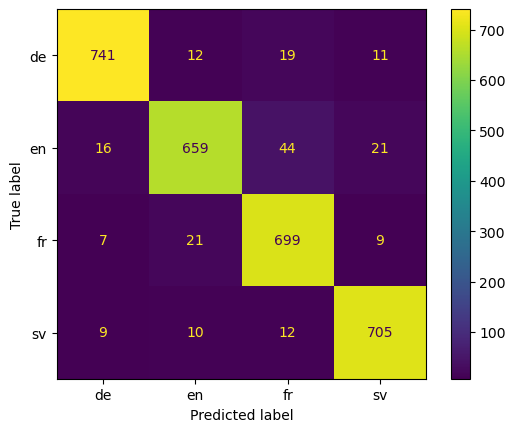

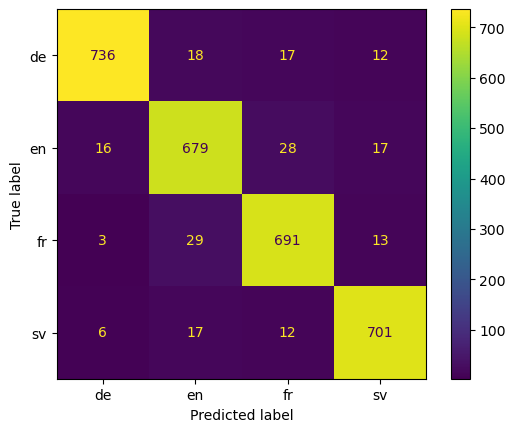

In [19]:
# perceptron regression confusion matrix
pcpt_sys_dev_y = pcpt.predict(dev_X)

pcpt_confusion_matrix = metrics.confusion_matrix(dev_y, pcpt_sys_dev_y)

pcpt_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = pcpt_confusion_matrix, display_labels = ["de", "en", "fr", "sv"])

pcpt_cm_display.plot()
plt.show()


# logistic regression confusion matrix
lr_sys_dev_y = lr.predict(dev_X)

lr_confusion_matrix = metrics.confusion_matrix(dev_y, lr_sys_dev_y)

lr_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = lr_confusion_matrix, display_labels = ["de", "en", "fr", "sv"])

lr_cm_display.plot()
plt.show()

## 6. Top-features (20 points)

You will now extract features which have large parameter values. These are features which your models emphasize strongly in classification, so they should be very informative.

Find the 10 strongest features for the English class (the 10 features with the highest parameter values in the en parameter vectors) and the 10 most positive  features for the French class. Find these features both for your perceptron and logistic regression models. 

Note, that: 

* You will need to access the string representations of your features. `vectorizer.get_feature_names()` will help here. 
* You'll also need to access the parameter vectors of your models. These you can get using `model.coef_[i]`, where `model` is either you logistic regression model or your perceptron model, and `i` is the ID number of the class. 
* You'll need to use `encoder.classes_` to figure out which ID number corresponds to which language tag (de, en, fr or sv). 

In your report (question 7), you should answer the following questions:
1. Do these features correspond to your intuition?
1. Do the perceptron and logistic regression models find similar top-features?


In [20]:
# get label and index correspondance
print(label_encoder.classes_)
print(label_encoder.transform(label_encoder.classes_))

['de' 'en' 'fr' 'sv']
[0 1 2 3]


In [21]:
# get string representation of features
vectorizer = DictVectorizer()
train_features = feature_extraction(train)
train_X = vectorizer.fit_transform(train_features)
features = vectorizer.get_feature_names_out()


In [22]:
# get the top 10 features for English and French for both models
# perceptron model
print("------------- perceptron model top features -------------")
print("------------- English top features -------------")
top_10_en_feature_index = np.argsort(pcpt.coef_[1])[-10:]
for idx in top_10_en_feature_index:
    print(features[idx])

print("------------- French top features -------------")
top_10_fr_feature_index = np.argsort(pcpt.coef_[2])[-10:]
for idx in top_10_fr_feature_index:
    print(features[idx])
    
# logistic regression model
print("------------- logistic regression model top features -------------")
print("------------- English top features -------------")
lr_top_10_en_feature_index = np.argsort(lr.coef_[1])[-10:]
for idx in lr_top_10_en_feature_index:
    print(features[idx])
print("------------- French top features -------------")
lr_top_10_fr_feature_index = np.argsort(lr.coef_[2])[-10:]
for idx in lr_top_10_fr_feature_index:
    print(features[idx])

------------- perceptron model top features -------------
------------- English top features -------------
char_bigram=ed
char_trigram=the
char_bigram= c
word_suff_2=ed
word_suff_1=y
word_suff_3=and
char_bigram=ea
EN_common_word=YES
word_suff_4=and
char_bigram=th
------------- French top features -------------
word_suff_3=les
char_trigram= se
char_bigram=ai
word_suff_2=nt
char_unigram=è
word_suff_3=en
word_suff_4=en
char_bigram=te
char_unigram=é
FR_common_word=YES
------------- logistic regression model top features -------------
------------- English top features -------------
char_pentagram=later
word_suff_4=yeah
word_suff_4=you
word_suff_3=oh
char_pentagram= patt
char_quadgram=hire
word_suff_3=ome
word_suff_4=nasa
char_quadgram=reer
word_suff_4=two
------------- French top features -------------
word_suff_4=voir
word_suff_2=y
word_suff_4=ans
char_trigram=eur
char_pentagram= cett
word_suff_3=bre
char_pentagram=du de
char_bigram=vé
char_unigram=è
char_quadgram=kesp


## 7. Short report (10 points)

Write a short report (half a page) describing what you did in this assignment. Please include answers to the questions posed in each individual assignment 1-6.

### Overview
In this assignment, I trained two classifiers to classify language based on given text. Firstly, I loaded datasets (train, development and test) of sentence fragment text of four different languages, incluing German, English, French, and Swedish. Secondly, I came up with some features and then vectorized the features. Then I build two classifiers, one Perceptron classifier and one Logistic regression classifier. The two classifiers then got fine tuned using the development dataset and evaluated using test dataset. Then I comparied the performance of the two classifiers, and I plotted the confusion matrix of each classifier to exhibit which language is usually mis-classified. Finally, I extracted the top features found by the two classifers when predicting English and French. The following paragraphs will answer questions in each task.
### Description on initial features (task 2)
The initail features that I proposed were on three categories, inclduing character n-gram, number of inflected words, and common words in each langauge. Specifically, character n-gram features include character bi-gram and tri-gram features. Number of inflected words features include the number of inflected words in a given sentence fragmant for each langauge. For the common words features, I came up with four common words lists, one for each language. The lists contain words such as articles, determiners, and different forms of be-verbs in each language. Then I proposed features that check whether the given text contains any word in the lists.
### Discuss why performance of the DummyClassifier is poor (task 3)
The DummyClassifier trained in task 3 only returns the most frequent label that it observed in the training dataset. In our case, labels in the training and development dataset are roughly distributed, and the most frequent label in the training is 2 (French) which is the least frequent label in the development dataset (takes less than 25%). Since the DummyClassifier only predict the most frequent lable in the training dataset, the True Positive cases for the other three labels is zero, which results in F1 score of 0 for those labels. For the 2 (French) label, the F1 score is slightly below 0.4, which results in a macro average F1 score just below 0.1.
### Hyperparameter fine tuning (task 4)
Apart from tuning the hyperparameters, I also improved my feature set. 
After I inspected the incorrectly classified token, I noticed that my features did not capture words that only has one character (e.g. y in French), and I noticed that some word would easily be classified by its suffix (e.g. s in English, gue in French). Hence, I added some features to the character n-gram inclduing unigram, 4-gram and 5-gram, and added some suffixing features includling the last character of each word, the last two characters of each word, the last three characters of each word, and the last four characters of each word.

For the Perceptron model, I only tuned the training epoch from 1 to 20. The results of the tuning process shows the best epoch is 14, and the F1-scocre reached 0.9359 after tuning, which increased from 0.9073 at pre-tuning.
For the Logistic regression model, I tuned the training epoch from 1 to 20, chose regularization method from "l1" and "l2", and chose regularization strength from 1, 5, and 10. The results of the tuning process shows the best epoch is 3, the best fegularization is l1, and the best strength is 5. The model reached F1-scocre of 0.9363 after tuning, which increased from 0.9112 at pre-tuning.
### Discussion on statistic test results (task 5)
The results of an Wilcoxon Signed Rank test showed that the p value is 0.049, which is greater than our threshold 0.005. Therefore, there is no significant difference between the performance of the Perceptron and the Logistric regression classifier.
### Most confused two languages (task 5)
The confusion matrices of both the Perceptron classifier and the logistic regression classifier show that English and French got confused by both models most often. The Perceptron classifer mis-classifed 44 English sentences as French, and 21 French sentence as English, results in a total number of 65 which outnumbers all other pairs of languages. The Logistic regression classifer mis-classifed 28 English sentences as French, and 29 French sentence as English, results in a total number of 57 which also outnumbers all other pairs of languages. This might be because that English borrowed a lot of words from French in the history. For instance, English words population, problem, and question are borrowed from French.
### Discussion on the top feature (task 6)
I don't speak French so I don't have speaker intuition for French. The following discssion is on the top features of English.
The top features found by the two classifiers are quite different. The top features used by the Perceptron classsifer look more intuitive to me than the top features used by the Logistic regression classifer. For the Perceptron classifier, apart from English common words, the top ranking features include character bigram -th-, bigram -ea-, suffix -ed, suffix -y, and suffix -and, which are all common forms in English but rare in other languages.

The top features used by the Logistic regression classifer are less intuitive. For instance, -two, -you, -yeah as suffices were used as top features. However they could only be as one specific word not as suffices. The character n-gram features, such as -hire-, -nasa-, -later-, -reer-, - patt- are also not as common as features like -th- mentioned above. Therefore, I think the features found by the Perceptron classifier is more sensible than those found by the Logistic regression classifier.